In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import datetime as dt
import pickle
import numpy as np
import borrador
from __future__ import division
from auxiliar_functions import *
import tfe
from geopy.distance import vincenty

## Funciones Auxiliares

In [3]:
#Función que filtra columnas de acuerdo a una lista de indices
#filter_features: matrix list -> matrix
def filter_features(vector,selected_features):
    selected = []
    for i in range(len(selected_features)):
        selected.append(features_dict[selected_features[i]])
    return vector[:,selected]

In [4]:
#Función que identifica cuantos rois comparten dos grupos de rois y cual es la minima distancia que se descarta como
#rois compartidos
#share_rois: list(dict) list(dict) -> [int,int]
def share_rois(rois_a,rois_b):
    shared = 0
    rois = [rois_a,rois_b]
    index = np.argmin([len(rois_a),len(rois_b)])
    other_index = abs(index-1)
    min_distance = -1
    for i in range(len(rois[index])):
        an_a_roi = rois[index][i]
        lat_a_roi = an_a_roi['lat']
        long_a_roi = an_a_roi['long']
        for j in range(len(rois[other_index])):
            an_b_roi = rois[other_index][j]
            lat_b_roi = an_b_roi['lat']
            long_b_roi = an_b_roi['long']
            a_distance = vincenty((lat_a_roi,long_a_roi),(lat_b_roi,long_b_roi)).meters
            if a_distance < 500:
                shared +=1
            elif min_distance == -1 or min_distance > a_distance:
                min_distance = a_distance
    return [shared,min_distance]

In [5]:
def compare_vectors(vector_a,vector_b,rois_a,rois_b,limit,min_shared):
    a_matrix = np.ones((limit, limit)) * -1
    init_time = time.time()
    shared = []
    for i in range(limit):
        rois_abril = rois_a[i]
        for j in range(limit):
            rois_septiembre = rois_b[j]
            min_shared_x = min(len(rois_abril),len(rois_septiembre),min_shared)
            share_RoIs,min_distance_not_shared = share_rois(rois_abril[0],rois_septiembre[0])
            shared.append(share_RoIs)
            if share_RoIs >= min_shared_x:
                a_sequence = vector_a[i]
                b_sequence = vector_b[j]
                dist = np.linalg.norm(np.asarray(a_sequence)-np.asarray(b_sequence))
                a_matrix[i,j] = -dist
    delta_time = time.time() - init_time
    print delta_time
    return a_matrix

In [32]:
def get_n_correct(a_matrix,limit):
    identified_indexs = [] #almacena los indices de que secuencia fue seleccionada como match
    wrong_indexs = [] # almacena los indices de los que se clasificaron incorrectamente
    correct_indexs = [] # almacena los indices de los que se clasificaron correctamente
    selected_distance = [] # almacena la distancia de los seleccionados
    n_identified = 0
    for i in range(limit):
        the_index = np.argmax(a_matrix[:,i])
        selected_distance.append(np.max(a_matrix[:,i]))
        identified_indexs.append(the_index)
        if(the_index!=i):
            wrong_indexs.append(the_index)
        else:
            correct_indexs.append(the_index)
            n_identified += 1
    return [n_identified,selected_distance,identified_indexs]


## Obtener datos

In [7]:
with open('data/datos_abril_sep_sequence.pickle') as f:
    datos_abril = pickle.load(f)
    datos_septiembre = pickle.load(f)

In [8]:
with open('data/feature_data.pickle') as f:
    abril_vectors = pickle.load(f)
    septiembre_vectors = pickle.load(f)

In [9]:
with open('data/rois_meters_data.pickle') as f:
    abril_the_rois = pickle.load(f)
    septiembre_the_rois = pickle.load(f)

In [10]:
limit = np.min((len(abril_vectors),len(septiembre_vectors)))
limit

5169

## Seleccionar Features para la comparación

In [11]:
features_names = ["msal","mlal","kmDistance","kmMaxDist","kmMinDist","rg","unc_entropy", \
    "random_entropy","p100_diff_last_origin","p100_diff_first_origin","card_type",\
    "start_time","end_time","traveled_days","traveled_days_bs","frequence_regularity",\
    "p100_exclusive_bus_days","p100_exclusive_metro_days","P100_bus_trips"]

In [12]:
features_dict = {"msal":0,"mlal":1,"kmDistance":2,"kmMaxDist":3,"kmMinDist":4,"rg":5,"unc_entropy":6,
                  "random_entropy":7,"p100_diff_last_origin":8,"p100_diff_first_origin":9,"card_type":10,
                  "start_time":11,"end_time":12,"traveled_days":13,"traveled_days_bs":14,"frequence_regularity":15,
                  "p100_exclusive_bus_days":16,"p100_exclusive_metro_days":17,"P100_bus_trips":18}

In [13]:
selected_features = ["msal","mlal","kmDistance","kmMaxDist","kmMinDist","rg","unc_entropy","random_entropy",\
                     "p100_diff_last_origin","p100_diff_first_origin","start_time","end_time",\
                     "traveled_days","frequence_regularity","P100_bus_trips"]

In [14]:
abril_selected_features = filter_features(abril_vectors,selected_features)
septiembre_selected_features = filter_features(septiembre_vectors,selected_features)

## Comparar

In [54]:
a_matrix = compare_vectors(abril_selected_features,septiembre_selected_features,abril_the_rois,septiembre_the_rois,limit,1)

5731.19753885


In [55]:
5731.19753885/60


95.51995898083332

In [56]:
n_identified,selected_distance,identified_indexs = get_n_correct(a_matrix,limit)

In [57]:
porcentaje_correcto = n_identified*100/limit
print str(round(porcentaje_correcto,2))+ "%"

20.08%


In [58]:
counter = []
for i in range(limit):
    #contar con cuantos comparte cada secuencia
    count = sum(x != -1 for x in a_matrix[i,:])
    counter.append(count)

Hay rois que son muy compartidos, por tanto quizás convenga ser más exigentes

(array([ 4.,  0.,  4., ...,  0.,  0.,  1.]),
 array([  1.00000000e+00,   2.11037344e+00,   3.22074689e+00, ...,
          1.33677925e+03,   1.33788963e+03,   1.33900000e+03]),
 <a list of 1205 Patch objects>)

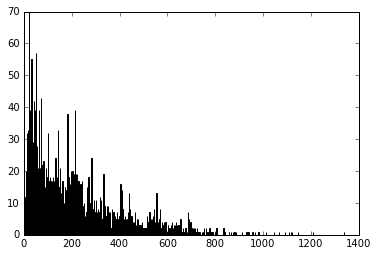

In [60]:
plt.hist(counter,1205)

### Comparar rendimiento cuando se seleccionan solo los que compartan dos rois

In [15]:
a_matrix = compare_vectors(abril_selected_features,septiembre_selected_features,abril_the_rois,septiembre_the_rois,limit,2)

5672.02297306


In [34]:
n_identified_2,selected_distance_2,identified_indexs_2 = get_n_correct(a_matrix,limit)

In [20]:
porcentaje_correcto = n_identified_2*100/limit
print str(round(porcentaje_correcto,2))+ "%"

44.55%


In [35]:
shared_rois_2_month = 0
changed_behaviour = []
for i in range(limit):
    if a_matrix[i,i] != -1:
        shared_rois_2_month += 1
    else:
        changed_behaviour.append(i)

In [36]:
print str(round(shared_rois_2_month*100/limit,2)) + "%"

54.85%


In [24]:
44.55/54.85*100

81.2215132178669

In [25]:
changed_behaviour

[1,
 7,
 10,
 12,
 15,
 16,
 20,
 22,
 27,
 28,
 29,
 31,
 34,
 35,
 36,
 39,
 40,
 42,
 43,
 46,
 50,
 51,
 52,
 53,
 56,
 57,
 58,
 60,
 63,
 66,
 67,
 69,
 70,
 73,
 74,
 76,
 77,
 78,
 80,
 82,
 85,
 88,
 90,
 92,
 94,
 96,
 102,
 103,
 106,
 107,
 109,
 111,
 112,
 115,
 116,
 117,
 119,
 121,
 122,
 123,
 124,
 129,
 134,
 135,
 138,
 139,
 141,
 142,
 144,
 146,
 148,
 149,
 150,
 151,
 153,
 155,
 156,
 157,
 158,
 160,
 162,
 167,
 168,
 170,
 173,
 175,
 178,
 182,
 183,
 189,
 191,
 194,
 195,
 196,
 197,
 198,
 199,
 200,
 201,
 203,
 205,
 208,
 213,
 214,
 215,
 217,
 220,
 221,
 222,
 223,
 224,
 225,
 227,
 229,
 231,
 234,
 237,
 241,
 243,
 247,
 250,
 251,
 254,
 255,
 261,
 262,
 263,
 266,
 271,
 273,
 275,
 276,
 278,
 280,
 284,
 286,
 288,
 289,
 291,
 292,
 298,
 299,
 300,
 301,
 304,
 305,
 309,
 311,
 313,
 314,
 316,
 317,
 320,
 321,
 322,
 324,
 325,
 326,
 329,
 330,
 332,
 333,
 334,
 336,
 339,
 340,
 341,
 345,
 348,
 351,
 355,
 357,
 359,
 360,
 361

In [37]:
identified_indexs_2

[0,
 0,
 2,
 1941,
 4,
 1435,
 6,
 2192,
 8,
 9,
 3197,
 11,
 3986,
 13,
 14,
 2698,
 0,
 17,
 18,
 19,
 0,
 21,
 800,
 23,
 24,
 25,
 26,
 0,
 0,
 3360,
 30,
 1248,
 32,
 33,
 0,
 1207,
 470,
 37,
 38,
 3327,
 0,
 41,
 0,
 0,
 44,
 45,
 0,
 47,
 0,
 49,
 2477,
 0,
 4592,
 1295,
 54,
 55,
 343,
 3728,
 0,
 59,
 1458,
 1730,
 62,
 3032,
 64,
 65,
 0,
 4430,
 3577,
 2706,
 800,
 71,
 72,
 879,
 800,
 75,
 1354,
 800,
 0,
 79,
 0,
 81,
 2291,
 83,
 84,
 0,
 4476,
 87,
 0,
 89,
 2207,
 91,
 1507,
 93,
 3536,
 95,
 596,
 97,
 98,
 99,
 100,
 101,
 0,
 2613,
 104,
 105,
 0,
 2430,
 108,
 0,
 110,
 2404,
 2528,
 113,
 114,
 2326,
 800,
 4291,
 118,
 0,
 4729,
 0,
 3838,
 0,
 0,
 125,
 126,
 127,
 128,
 0,
 130,
 131,
 132,
 133,
 0,
 0,
 3604,
 3598,
 1269,
 0,
 140,
 4297,
 0,
 143,
 686,
 145,
 0,
 3197,
 0,
 0,
 3032,
 709,
 4430,
 3057,
 154,
 0,
 1742,
 0,
 0,
 159,
 4233,
 161,
 0,
 163,
 164,
 165,
 166,
 0,
 5085,
 169,
 0,
 171,
 172,
 0,
 174,
 3753,
 176,
 177,
 0,
 179,
 180,
 181

In [38]:
x = np.array(identified_indexs_2)
y = np.bincount(x)
ii = np.nonzero(y)[0]


In [39]:
frequency_correct = zip(ii,y[ii]) 


In [40]:
counter = 0
ncounter = 0
freq_max_1 = 0
freq_max_2 = 0
freq_max_3 = 0
for element in frequency_correct:
    if(element[1]>1):
        counter +=1
        ncounter += element[1]
    

In [41]:
counter

598

In [42]:
ncounter

2891

In [43]:
frequency_correct.sort(key = lambda t: t[1], reverse=True)
frequency_correct

[(0, 1162),
 (4330, 49),
 (800, 44),
 (3057, 27),
 (1442, 16),
 (618, 14),
 (1645, 14),
 (1938, 11),
 (1990, 11),
 (2613, 11),
 (3900, 11),
 (1295, 10),
 (1726, 10),
 (2418, 10),
 (3646, 9),
 (4920, 9),
 (611, 8),
 (4103, 8),
 (384, 7),
 (586, 7),
 (3355, 7),
 (3510, 7),
 (3536, 7),
 (4430, 7),
 (4856, 7),
 (301, 6),
 (889, 6),
 (1385, 6),
 (2809, 6),
 (4944, 6),
 (462, 5),
 (580, 5),
 (804, 5),
 (1354, 5),
 (1525, 5),
 (1658, 5),
 (1778, 5),
 (2150, 5),
 (2207, 5),
 (2303, 5),
 (2756, 5),
 (3032, 5),
 (3197, 5),
 (3786, 5),
 (3948, 5),
 (4176, 5),
 (4850, 5),
 (5085, 5),
 (7, 4),
 (230, 4),
 (424, 4),
 (699, 4),
 (736, 4),
 (1085, 4),
 (1203, 4),
 (1209, 4),
 (1242, 4),
 (1269, 4),
 (1273, 4),
 (1306, 4),
 (1419, 4),
 (1551, 4),
 (1694, 4),
 (1933, 4),
 (2110, 4),
 (2132, 4),
 (2231, 4),
 (2372, 4),
 (2373, 4),
 (2627, 4),
 (2723, 4),
 (2767, 4),
 (2816, 4),
 (2981, 4),
 (3014, 4),
 (3209, 4),
 (3296, 4),
 (3304, 4),
 (3327, 4),
 (3344, 4),
 (3361, 4),
 (3424, 4),
 (3668, 4),
 (3805, 

In [29]:
with open('data/changed_behaviour.pickle', 'w') as f:
    pickle.dump(changed_behaviour, f)

In [33]:
with open('data/distance_meters_data_2_rois.pickle', 'w') as f:
    pickle.dump(a_matrix, f)

In [44]:
with open('data/freq_correct.pickle', 'w') as f:
    pickle.dump(frequency_correct, f)